# OpenSpiro Algorithm Development

## Audio File Signal Analysis

##### Import Statements 

In [2]:
from IPython.display import Javascript, display
import numpy as np
import pdb
from numpy import unravel_index
import json
from matplotlib import pyplot as plt
import scipy.io.wavfile as wavfile
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from ipywidgets import widgets
import pandas as pd
from scipy.signal import resample

##### Notebook Customization

In [3]:
# Forces graphs to display in notebook
%matplotlib inline

##### Global Functions

In [4]:
# Returns an int array with max values
def get_max_values (data, frequency_threshold = 0, sampling_rate = 0):    
    # Match the frequency threshold to an index in each column
    threshold_index = 0
    if frequency_threshold > 0 and sampling_rate > 0:
        threshold_index = int(frequency_threshold / ((sampling_rate / 2) / data.shape[0]))
    
    # Create a magnitude threshold which prevents low values from breaking up curves
    magnitude_threshold = 0.00005 * data.max()
    
    # Create an empty array of the same length as the data array
    max_array = np.zeros(data.shape[1], dtype=int)
    # Iterate through all columns of the FFT data
    previous_max_location = 0
    for i in range(0, data.shape[1]):
        col = data[threshold_index :, i]
        max_location = int(np.argmax(col) + threshold_index)
        if data[max_location, i] < magnitude_threshold:
            max_location = previous_max_location
        max_array[i] = max_location   #Location of the highest value, not the value itself    
        previous_max_location = max_location
    return max_array

In [5]:
# sampling_rate ÷ fft_n represents the number of rows in the data set.
# ... fft_n corresponds to the num of rows that would be in the data set if the symmetric half was not removed
# ... this is the same as calculating (sampling_rate / 2) ÷ (fft_n / 2)

# PRECISION NOTE: Both of these funcitons have a precision of around ~22Hz

def index_to_freq(index):
    return float(index) * ( float(sampling_rate) / float(fft_n) )

def freq_to_index(freq):
    return int( float(freq) / ( float(sampling_rate) / float(fft_n) ) )

In [6]:
def time_to_index(time, sampling_rate):    
    return int(float(time) * float(sampling_rate))

def index_to_time(index, sampling_rate):    
    return float(index) / float(sampling_rate)

In [7]:
def run_below():
    display(Javascript('IPython.notebook.execute_cells_below()'))

In [8]:
def convert_file_to_file_path(atsfile):
    prefix = "Waveform/"

    if atsfile.find("ATS24.") >= 0:
#         prefix += "ATS24/"
#         tmp = atsfile.split(".")
#         prefix += "24%02d.wf"%(int(tmp[1]))

#     elif atsfile.find("ATS24*.") >= 0:
        prefix += "ATS24v2/"
        tmp = atsfile.split(".")
        prefix += "24%02d.wf"%(int(tmp[1]))

    elif atsfile.find("ATS26.") >= 0:
        prefix += "ATS26/"
        tmp = atsfile.split(".")
        prefix += "26%02d.wf"%(int(tmp[1]))

    elif atsfile.find("Prof") >= 0:
        prefix += "ISO23747/"
        prefix += atsfile + ".wf"

    elif atsfile.find("ISO2678") >= 0:
        prefix += "ISO26782/"
        tmp = atsfile.split(".")
        prefix += "26782%02d.wf"%(int(tmp[1]))

    elif atsfile.find("Custom") >= 0:
        tmp = atsfile.split(".")
        prefix += "Custom%02d.wf"%(int(tmp[1]))
    else:
        return None

    return prefix

In [9]:
def read_waveform_data( atsfile):

    if atsfile is None: # not a PWG waveform
        return None

    filepath = convert_file_to_file_path(atsfile)

    waveform_data = {}
    waveform_data["Header"]={}
    waveform_data["Parameters"]={}
    waveform_data["Data"]=[]
    currSection = ""
    with open(filepath) as f:
        data = f.readlines()
        for dline in data:
            sectionChanged = False
            # know the current section
            for sec in ["Header","Parameters","Data"]:
                if dline.find(sec) != -1:
                    currSection = sec
                    sectionChanged = True 
            if sectionChanged:
                continue 
                
            dline = dline.strip()
            if (currSection=="Header" or currSection=="Parameters") and len(dline)>1:
                keyval = dline.split("=")
                if keyval[1][0].isdigit():
                    keyval[1] = float(keyval[1])
                waveform_data[currSection][keyval[0]] = keyval[1]
            elif currSection=="Data" and len(dline)>1:
                waveform_data[currSection].append(float(dline))
    return waveform_data

##### Audio Variables

In [10]:
# Global variables for use by dropdown call-back
global sampling_rate, raw_data, sampling_rate_columns, wav_form, meta
# Original sampling rate divided by overlap since there will be a new window every [fft_shift] points 
# https://db.tt/4lOSyLeO 

# FFT Variables
# Number of points in each FFT window
fft_n = 2048

# Number of points each subsequent window is shifted
fft_shift = 128

In [11]:
# Open JSON file containing info about audio files
with open('audio_curve_data/Final_Data/010.json') as audio_data_json:    
    audio_files_data = json.load(audio_data_json)

# Retrieve the name of all audio files for dropdown
tests = audio_files_data['Tests']
audio_files = {}
audio_files_list = []
for i in range(0, len(tests)):
    # IGNORE ALL YELLOW SIDESTACK TESTS
    if tests[i]['Sidestack'] != 'Sidestack C (Yellow)':
        test = tests[i]
        efforts = test['Efforts']
        for j in range(0, len(efforts)):
            effort = efforts[j]
            effort_data = {}
            file_name = effort['RecordedAudioFilenameForEffort']
            if i + 1 < 10:
                test_string = '0' + str(i + 1) + '_' + str(j + 1) + ' - ' + test['PWGFile'] + ' ' + test['Sidestack']
            else:
                test_string = str(i + 1) + '_' + str(j + 1) + ' - ' + test['PWGFile'] + ' ' + test['Sidestack']
            effort_data['WavFile'] = file_name
            effort_data['PWGFile'] = test['PWGFile']
            
            sidestack = test['Sidestack']
            downstream = test['DownstreamTube']
            ball = test['Ball']
            mouthpiece = test['Mouthpiece']
            effort_data['Metadata'] = sidestack + downstream + mouthpiece + ball
            
            audio_files[test_string] = effort_data
            audio_files_list.append(test_string)


# DEFAULT AUDIO FILE - If this file is changed, change the default file shown by the dropdown as well
# Import data from an audio file, save sampling rate and raw data
# default_file = '1464278801.365085.wav'

audio_files_list.sort()


# Create UI element for selecting waveform file
json_selector = widgets.Dropdown(
    options=audio_files_list,
    description='Waveform File:'
#     value=default_file
)

display(json_selector)

def on_value_change(change):
    update_data(change['new'])
    
def update_data(file):
    global sampling_rate, raw_data, sampling_rate_columns, wav_form, meta
    effort = audio_files[file]
    file_name = effort['WavFile']
    
    sampling_rate, raw_data = wavfile.read("audio_curve_data/Final_Data/" + file_name)
    sampling_rate_columns = sampling_rate / fft_shift
    wav_form = read_waveform_data(effort['PWGFile'])
    meta = effort['Metadata']
    print 'File:', json_selector.value
    print '\t', effort['PWGFile'], '\n\t', effort['WavFile'], '\n\t', meta
#     run_below()
    
json_selector.observe(on_value_change, names='value')

update_data(json_selector.value)

#40_1 Sidestack A (Red) is good
#40_0 Sidestack A (Red) is good

# 10_0
# 8_0 > Great test

# LAST:45_0

# GOOD TEST: 30_1

File: 01_1 - ATS24.3 Sidestack (Red)
	ATS24.3 
	1464277463.883373.wav 
	Sidestack (Red)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)


/Users/Spencer/anaconda/lib/python2.7/site-packages/scipy/io/wavfile.py:221: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


File: 05_1 - ATS24.8 Sidestack (Purple 2)
	ATS24.8 
	1464278340.201364.wav 
	Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
File: 07_1 - ATS24.11 Sidestack (Purple 2)
	ATS24.11 
	1464278504.581902.wav 
	Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
File: 08_1 - ATS24.12 Sidestack (Purple 2)
	ATS24.12 
	1464278624.053703.wav 
	Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
File: 09_1 - ATS24.14 Sidestack (Purple 2)
	ATS24.14 
	1464278683.074514.wav 
	Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
File: 10_1 - ATS24.23 Sidestack (Purple 2)
	ATS24.23 
	1464278741.611514.wav 
	Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
File: 11_1 - ATS26.4 Sidestack (Purple 2)
	ATS26.4 
	1464278801.365085.wav 
	Sidestack (Purple 2)Downstream A (Blue)Mouthpiece B (Red)0% Infill (Blue)
File: 12_1 - ATS26.5 Sidestack (Purple 2)
	ATS26.5 
	1464278902.937519.wav 
	Sidestack

- 40_1 - 125.0 Hz
- 09_1 - 125.0 Hz

Bad Tests:
- 01_1
- 01_2
- 02_1
- 03_1
- 04_1
- 07_1
- 10_1
- 13_1
- 14_1
- 22_1
- 23_1
- 25_1
- 25_2
- 26_1
- 50_1 : too much flow

Errors
- 09_01
- 11_1
- 12_1
- 18_1 : Missed front whistle
- 47_1 : Didn't get good peak for vortex
- 49_1 : Didn't get good peak for vortex

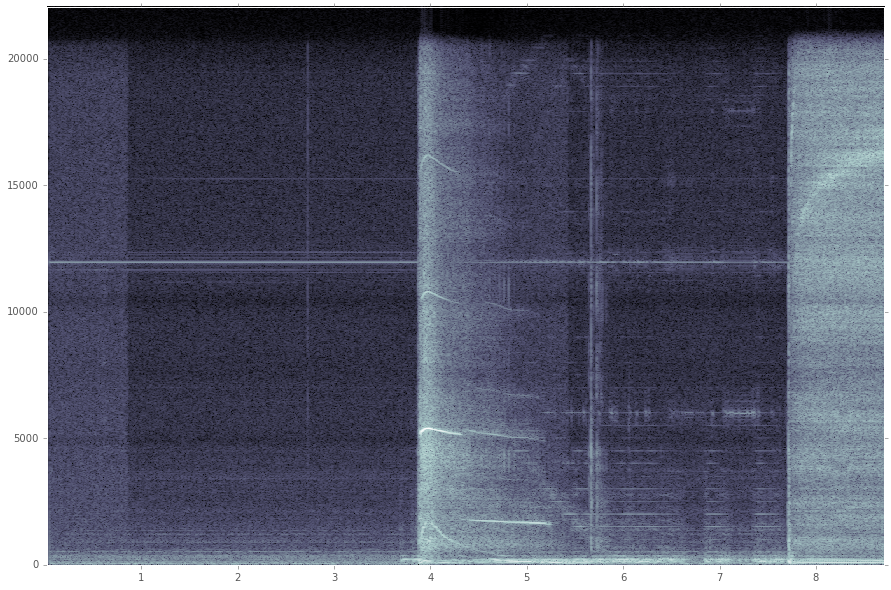

In [638]:
# Plot the raw spectrogram of the audio data 
f = plt.figure(figsize=(15,10)) 
plt.style.use('ggplot') 
 
data, data_freq, data_time, _ = plt.specgram(raw_data, NFFT=fft_n, Fs=sampling_rate, noverlap=(fft_n-fft_shift) ) 
# data is basically a matrix of magnitudes
# data_freq is a single column with the same number of rows as data where each row is a frequency (0 - fs/2) 
# data_time is an array of columns the same length as data where each index contains the time value at that column (0 - ~19) 
data[data==0] = 0.0001 
    
 
# Clear original figure 
f.clear() 
 
# Plot a customized figure 
ax = plt.subplot(1,1,1) 
ax.pcolorfast(data_time, data_freq, np.log(data+0.00001), cmap=plt.cm.bone) 
plt.grid()

4.11890904257


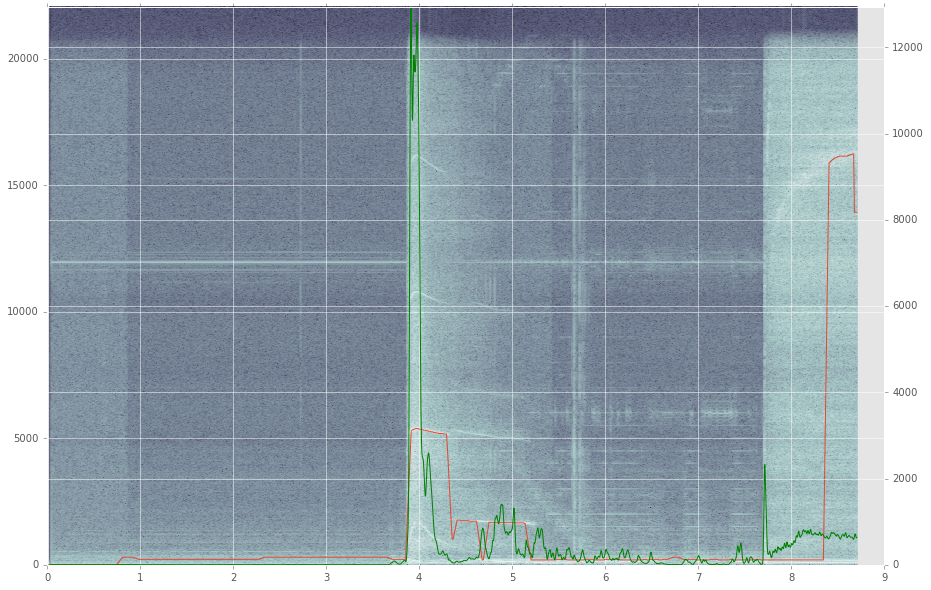

In [639]:
frequency_threshold = 200
max_values = get_max_values(data, frequency_threshold, sampling_rate)

med_window_length = 31
max_values = medfilt(max_values, med_window_length)

sg_window_length = 21
poly_order = 1
max_values = savgol_filter(max_values, sg_window_length, poly_order, mode='mirror')

# print max_values
max_values = max_values.round(decimals=0)
max_values = max_values.astype(int)
# print max_values

# Plot Modification
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')

ax = plt.subplot(1,1,1)
ax.pcolorfast(data_time, data_freq, np.log(data), cmap=plt.cm.bone)
ax.plot(data_time, max_values*sampling_rate/fft_n)
# max_values is a 1D array containing the vertical index which represents the max value for any given slice
# ... because this value is NOT a frequency, we must map it to the correct frequency by multiplying the value by 
# ... sampling_rate/fft_n which is generated by the following:
# ... The FFT returns a symmetric graph from 0 to fft_n, but because it's symmetric, half must be removed (fft_n/2)
# ... then to map a frequency to an index, the sampling rate must be divided by 2 (fs/2)... finally, to map the two,
# ... any index from fft_n/2 must be mapped to fs/2, resuling in fs/2 ÷ fft_n/2 OR fs/fft_n

# Calculate the overall energy by summing each column
cols = 0
db_data = np.log(data[(data_freq>200) & (data_freq<4000),:]) 
energy = np.max(db_data,axis=cols)
db_min = np.percentile(energy,10)
print db_min
energy = energy - db_min

energy = np.mean(data, axis=cols)

# Graph it on top of the spectrogram
ax2 = ax.twinx()
plt.ylim(0, max(energy))
ax2.plot(data_time, energy, 'g')

## Feature Extraction

##### Variable Declaration

In [640]:
# Create variables for various features (curves)

#REMOVE
# Curve which will be used for the analysis
# data_curve = max_values*sampling_rate/fft_n
# data_curve = max_values
# The data is multiplied by the sampling_rate/fft_n to map y-indices to frequencies

# whistle_endpoints: the whistle at the beginning and end of the test
whistle_endpoints = np.empty(data.shape[1])
whistle_endpoints[:] = np.nan

# whistle_midsection: the whistle (during vortex) after jumping in frequency
whistle_midsection = np.empty(data.shape[1])
whistle_midsection[:] = np.nan

# whistle_combined_normalized: a curve combining all whistle components, including a normalized midsection
whistle_combined_normalized = np.empty(data.shape[1])
whistle_combined_normalized[:] = np.nan

# vortex_fundamental: a curve representing the extracted vortex curve
vortex_fundamental = np.empty(data.shape[1])
vortex_fundamental[:] = np.nan

# vortex_harmonics: an array for additional vortex harmonics (should they be detected)
vortex_harmonics = []

##### CURVE ANALYSIS ALGORITHM

In [641]:
# Find point of max energy from the energy curve
print len(energy)
max_energy_loc = np.argmax(energy[0 : int(len(energy) * .8)])
max_energy = energy[max_energy_loc]
# max_energy_time = index_to_time(max_energy_loc, sampling_rate_columns)


# Find # of index points in 1/2 second... create window of max_energy_location ± index
search_window_time = 0.25
search_window_shift = time_to_index(search_window_time, sampling_rate_columns)
search_window_begin = max_energy_loc - search_window_shift
search_window_end = max_energy_loc + search_window_shift + 1
# +1 was added to account for python array indexing


# Search through max_values to find the temp point of max magnitude (in the search window)
init_max_mag_x = np.argmax(max_values[search_window_begin : search_window_end]) + search_window_begin
init_max_mag_y = max_values[init_max_mag_x]

# init_max_mag_time = index_to_time(init_max_mag_x, sampling_rate_columns)


# Follow this curve within a band of ±30Hz and find end points to determine whistle mid-section
search_index = init_max_mag_x - 1


2993


In [642]:
def identify_curve(data, curve, x_index, y_index, band_index, signal_threshold = 5.0, lookahead = 5):
    def get_signal_significance():
        # INNER
        # Inner mean is the mean of the values surrounding the max within ± X Hz
        inner_lower_y = y_index - band_index
        if inner_lower_y < 0:
            inner_lower_y = 0
            
        inner_upper_y = y_index + band_index + 1
        if inner_upper_y >= data.shape[0]:
            inner_upper_y = data.shape[0] - 1
        
        inner_window = data[inner_lower_y : inner_upper_y, x_index]
        inner_mean = np.mean(inner_window)
#         inner_mean = np.max(inner_window)

        # OUTER
        outer_band_index = band_index * 3
        outer_lower_y = inner_lower_y - outer_band_index
        if outer_lower_y < 0:
            outer_lower_y = 0
            
        outer_upper_y = inner_upper_y + outer_band_index
        if outer_upper_y > data.shape[0]:
            outer_upper_y = data.shape[0] - 1

        lower = data[outer_lower_y : inner_lower_y, x_index]
        upper = data[inner_upper_y : outer_upper_y, x_index]
        outer_window = np.concatenate([lower, upper], axis=0)

        outer_mean = np.mean(outer_window)
#         outer_mean = np.max(outer_window)
    
        max_y_loc = np.argmax(inner_window) + inner_lower_y
        
#         print "Inner:", "[", inner_lower_y, "-", inner_upper_y, ")"
#         print "Outer:", "[", outer_lower_y, "-", inner_lower_y, ") & [", inner_upper_y, "-", outer_upper_y, ")"
#         print "\n", "inner_window length:", len(inner_window)
#         print "outer_window length:", len(outer_window), "\n", len(lower), len(upper)
        
#         pdb.set_trace()
        return inner_mean/outer_mean, max_y_loc
    
    # Save original values
    orig_x = x_index
    orig_y = y_index
    orig_band_index = band_index
    
    # TRACE CURVE BACKWARDS
    signal_significance = 100.0
    end_found = False
    while not end_found:
        signal_significance, max_y_loc = get_signal_significance()
        if signal_significance >= signal_threshold:
            # Signal is still significant, continue following
            curve[x_index] = max_y_loc
            x_index -= 1
            y_index = max_y_loc
            # Resetting band in case it needed to be adjusted by the expanded search
            band_index = orig_band_index
        else:
            # Signal is no longer significant, look ahead and continue
            end_found = True
            curve_start = x_index + 1
            
            for i in range(0, lookahead):
                x_index -= 1
                signal_significance, max_y_loc = get_signal_significance()
                if signal_significance >= signal_threshold:
                    end_found = False
                    # Store the y-value so it can be found on the next full pass
                    y_index = max_y_loc

                        # Return back to index before so the next loop grabs the value
                    band_index = orig_band_index
                    break

            if end_found:
                x_index = curve_start
                band_index *= 2
                for i in range(0, lookahead):
                    x_index -= 1
                    signal_significance, max_y_loc = get_signal_significance()
                    if signal_significance >= signal_threshold:
                        end_found = False
                        # Store the y-value so it can be found on the next full pass
                        y_index = max_y_loc

                        # Return back to index before so the next loop grabs the value
                        break
            
            if end_found:
                x_index = curve_start
                band_index = orig_band_index
                band_index /= 2
                for i in range(0, lookahead):
                    x_index -= 1
                    signal_significance, max_y_loc = get_signal_significance()
                    if signal_significance >= signal_threshold:
                        end_found = False
                        # Store the y-value so it can be found on the next full pass
                        y_index = max_y_loc

                        # Return back to index before so the next loop grabs the value
                        break 

    # TRACE CURVE FORWARDS
    x_index = orig_x
    y_index = orig_y
    band_index = orig_band_index
    
    signal_significance = 100.0
    end_found = False
    while not end_found:
        signal_significance, max_y_loc = get_signal_significance()
        if signal_significance >= signal_threshold:
            # Signal is still significant, continue following
            curve[x_index] = max_y_loc
            x_index += 1
            y_index = max_y_loc
            # Resetting band in case it needed to be adjusted by the expanded search
            band_index = orig_band_index
        else:
            # Signal is no longer significant, look ahead and continue
            end_found = True
            curve_end = x_index - 1
            
            for i in range(0, lookahead):
                x_index += 1
                signal_significance, max_y_loc = get_signal_significance()
                if signal_significance >= signal_threshold:
                    end_found = False
                    y_index = max_y_loc
                    break
        
            if end_found:
                band_index *= 2
                x_index = curve_end
                for i in range(0, lookahead):
                    x_index += 1
                    signal_significance, max_y_loc = get_signal_significance()
                    if signal_significance >= signal_threshold:
                        end_found = False
                        y_index = max_y_loc
                        break
            
            if end_found:
                band_index = orig_band_index
                band_index /= 2
                x_index = curve_end
                for i in range(0, lookahead):
                    x_index += 1
                    signal_significance, max_y_loc = get_signal_significance()
                    if signal_significance >= signal_threshold:
                        end_found = False
                        y_index = max_y_loc
                        break
    
    # print signal_significance
    return curve_start, curve_end


# When investigating a dead signal, attempt to figure out where the next point SHOULD be...
# - Slope of past 3 points
# - Slope since origin
# - Regression of curve so far

In [643]:
x_index = init_max_mag_x
y_index = init_max_mag_y
band_index = freq_to_index(50.0)

# WHISTLE MIDSECTION
print "Looking for midsection"
curve_start, curve_end = identify_curve(data, whistle_midsection, x_index, y_index, band_index, lookahead=0)
midsection_start = curve_start
midsection_end = curve_end


# band_range = freq_to_index(100.0)


# FRONT WHISTLE
print "Looking for front whistle"

# Find a relevant y-index for for the beginning of the front whistle
front_y_index = int(whistle_midsection[midsection_start + 1] / 3)
front_y_index = int(np.argmax(data[front_y_index - band_index : front_y_index + band_index, midsection_start])) + front_y_index - band_index

curve_start, curve_end = identify_curve(data, whistle_endpoints, midsection_start, front_y_index, band_index, lookahead=10)
front_whistle_start = curve_start
front_whistle_end = curve_end
print "Front Whistle:", front_whistle_start, front_whistle_end

if np.isnan(front_whistle_start):
    front_whistle_start = midsection_start
    front_whistle_end = midsection_start




# BACK WHISTLE
print "Looking for back whistle"

# Find a relevant y-index for for the beginning of the back whistle
end_y_index = int(whistle_midsection[midsection_end - 1] / 3)
end_y_index = int(np.argmax(data[end_y_index - band_index : end_y_index + band_index + 1, midsection_end])) + end_y_index - band_index
temp_x = midsection_end
temp_y = end_y_index

curve_start, curve_end = identify_curve(data, whistle_endpoints, midsection_end, end_y_index, band_index, lookahead=10)

if np.isnan(back_whistle_start):
    curve_start, curve_end = identify_curve(data, whistle_endpoints, midsection_end, front_y_index, band_index, lookahead=10)

back_whistle_start = curve_start
back_whistle_end = curve_end

if np.isnan(back_whistle_start):
    back_whistle_start = midsection_end
    back_whistle_end = midsection_end


    
# ADDITIONAL WHISTLE DATA POINTS
whistle_min = np.nan
if np.isnan(whistle_endpoints).all():
    whistle_min = int(np.nanmin(whistle_midsection))
else:
    whistle_min = int(np.nanmin(whistle_endpoints))
print "Min Whistle Freq:", index_to_freq(whistle_min), "(Y-Index:", whistle_min, ")"

whistle_max = int(np.nanmax(whistle_midsection))
print "Max Whistle Freq:", index_to_freq(whistle_max), "(Y-Index:", whistle_max, ")" 

midsection_min = int(np.nanmin(whistle_midsection))
midsection_max = int(np.nanmax(whistle_midsection))


Looking for midsection
Looking for front whistle
Front Whistle: 1331 1329
Looking for back whistle
Min Whistle Freq: 5146.43554688 (Y-Index: 239 )
Max Whistle Freq: 5383.30078125 (Y-Index: 250 )


In [644]:
# VORTEX FUNDAMENTAL
print "Looking for vortex fundamental"

# Define initial search area for vortex fundamental
area_width = back_whistle_start - front_whistle_end
midpoint = front_whistle_end + area_width/2
expansion = int(area_width*.25)
window_start = midpoint - expansion
window_end = midpoint + expansion

bottom_noise_index = 20
search_area = data[bottom_noise_index : midsection_min - 1, window_start : window_end]

# search_area = data[20 : midsection_min - 1, front_whistle_end : back_whistle_start]
# search_area = data[20 : whistle_min - 1, front_whistle_end : back_whistle_start]

# If front whistle continues across entire test
if front_whistle_end > back_whistle_end:
    print "Search area modified due to whistle anomaly"
    search_area = data[bottom_noise_index : whistle_min - 1, midsection_start : midsection_end]
    window_start = midsection_start
    
peak_vortex_mag = unravel_index(search_area.argmax(), search_area.shape)

peak_vortex_mag_y = peak_vortex_mag[0] + bottom_noise_index
peak_vortex_mag_x = peak_vortex_mag[1] + window_start

# Modifying band_index significantly impacts the significance detection

midsection_range = midsection_max - midsection_min
print midsection_range

band_index = freq_to_index(125.0)

# 14 - 125.0 Hz


# Removing whistle components from data
core_data = np.copy(data)
# core_data = data

if front_whistle_start and front_whistle_end:
    core_data[whistle_min - 1 : , front_whistle_start - 1 : front_whistle_end + 1] = np.nan

if back_whistle_start and back_whistle_end:
    core_data[whistle_min - 1 : , back_whistle_start - 1 : back_whistle_end + 1] = np.nan
    
curve_start, curve_end = identify_curve(core_data, vortex_fundamental, peak_vortex_mag_x, peak_vortex_mag_y, band_index, signal_threshold=1.2, lookahead = 10)
vortex_start = curve_start
vortex_end = curve_end

print front_whistle_start, front_whistle_end, midsection_start, midsection_end, back_whistle_start, back_whistle_end



# TO DO
# if there is a front whistle, truncate vortex at that point

if np.isfinite(front_whistle_start):
    vortex_fundamental[:front_whistle_start] = np.nan

# # VORTEX HARMONICS
# harmonics = {}

# for i in range(2, 25):
#     harmonic_y = int(peak_vortex_mag_y * i)
#     if harmonic_y >= data.shape[0]:
#         break

#     if harmonic_y > whistle_max:
#         curve = np.empty(data.shape[1])
#         curve[:] = np.nan
#         harmonic_y = int(np.argmax(data[harmonic_y - 2 : harmonic_y + 3, back_whistle_start])) + harmonic_y - 2

#         harmonics[i] = harmonic_y
    
#         band_index = freq_to_index(30.0)
#         curve_start, curve_end = identify_curve(data, curve, peak_vortex_mag_x, int(peak_vortex_mag_y * i), band_index, signal_threshold=1.5, lookahead = 15)
#         vortex_harmonics.append(curve)

Looking for vortex fundamental
11
1331 1329 1330 1483 1484 1482


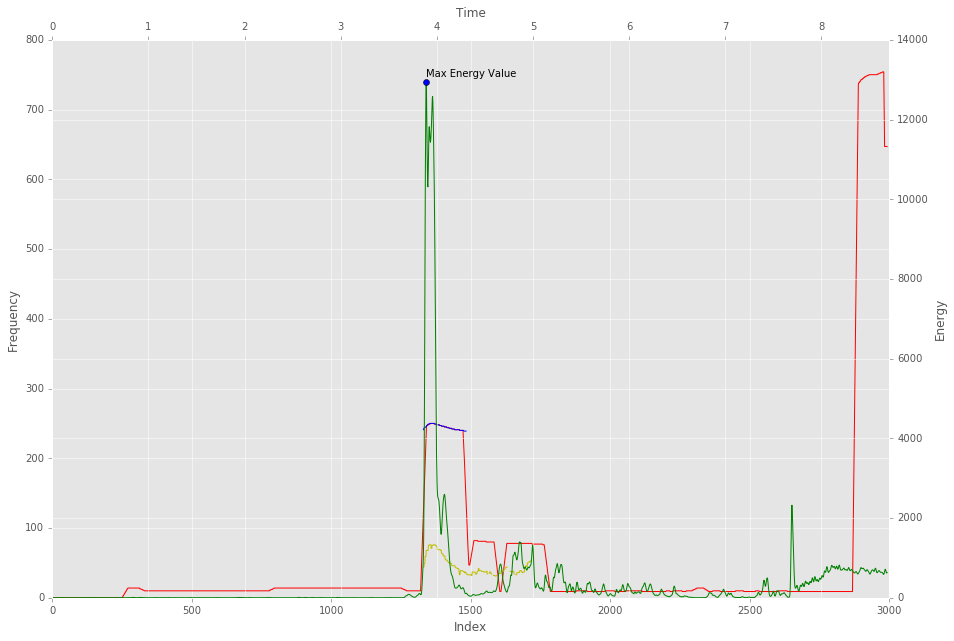

In [645]:

# NOTE: When trying to graph curves, either use the data_freq array as the y-axis labels
# ... or multiply the data by sampling_rate/fft_n to map indices to frequencies
data_curve = max_values * sampling_rate/fft_n

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Index')
ax.set_ylabel('Frequency')

ax.plot(max_values, 'r')

# ax.plot(search_window_begin, max_values[search_window_begin], 'og')
# ax.text(search_window_begin, max_values[search_window_begin], 'Search Start')
# ax.plot(search_window_end, max_values[search_window_end], 'or')
# ax.text(search_window_end, max_values[search_window_end], 'Search Stop')

# ax.plot(init_max_mag_x, init_max_mag_y, 'or')
# ax.text(init_max_mag_x, init_max_mag_y - init_max_mag_y*0.01, 'Max Mag (Init)')


# ax.plot(curve_end, init_y_index, 'or')
# ax.text(curve_end, init_y_index, 'WAT')
ax.plot(whistle_midsection, 'b')
ax.plot(whistle_endpoints, 'b')
ax.plot(vortex_fundamental, 'y')


# Add time as a second x-axis
ax2 = ax.twiny()
ax2.set_xlim(0, data_time[-1])
ax2.set_xlabel('Time')


# Add energy as a second y-axis
ax3 = ax.twinx()
ax3.set_ylabel('Energy')

ax3.plot(energy, 'g')
ax3.plot(max_energy_loc, max_energy, 'ob')
ax3.text(max_energy_loc, max_energy + 0.01*max_energy, 'Max Energy Value')

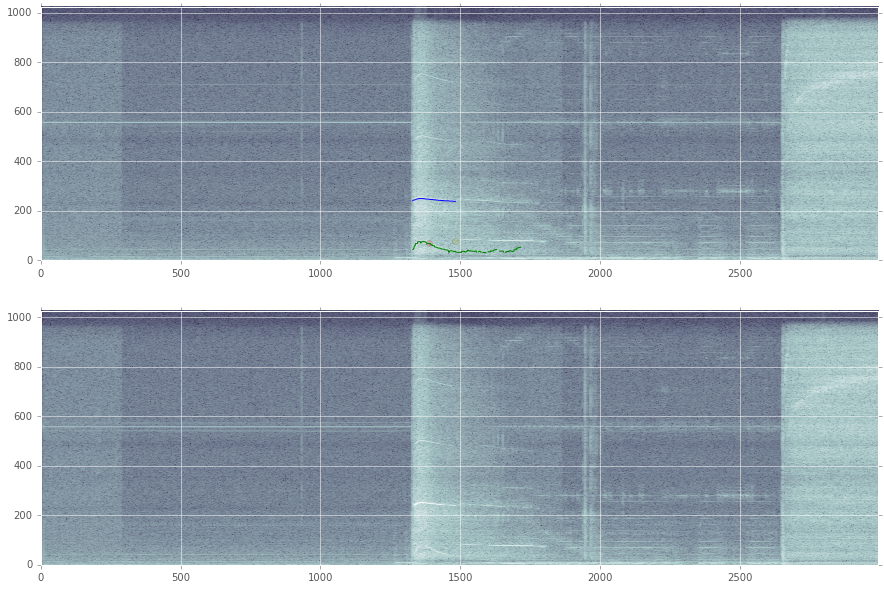

In [646]:
f = plt.figure(figsize=(15,10))
plt.style.use('ggplot')


# data[20 : midsection_min - 1, midpoint - expansion : midpoint + expansion] *= 100

ax = plt.subplot(2,1,1)
# ax = plt.subplot(1,1,1)
data[:bottom_noise_index, :] *= .1

ax.pcolorfast(np.log(data), cmap=plt.cm.bone)
ax2 = plt.subplot(2,1,2)
ax2.pcolorfast(np.log(data), cmap=plt.cm.bone)

ax.plot(temp_x, temp_y, 'oy', alpha=.2)

# ax.plot(init_max_mag_x, init_max_mag_y, "or")

# ax.plot(max_values)
ax.plot(whistle_midsection, 'b')
ax.plot(whistle_endpoints, 'b')

# ax.plot(peak_vortex_mag_x, peak_vortex_mag_y , 'or')
ax.plot(peak_vortex_mag_x, peak_vortex_mag_y , 'or', alpha=.2)
# ax.plot(midsection_start, front_y_index, 'or', alpha=.2)
# ax.plot(midsection_end, end_y_index, 'or', alpha=.2)
# ax.plot(curve_end, init_y_index, 'or')


# for curve in vortex_harmonics:
#     ax.plot(curve, 'g')


ax.plot(vortex_fundamental, 'g')


In [647]:
crop_start = 0

temp = np.isfinite(whistle_midsection) | np.isfinite(whistle_endpoints) | np.isfinite(vortex_fundamental)

for i in range(0, len(temp)):
    if temp[i] == 1:
        crop_start = max(i-300,0)
        
        break

cropped_midsection = whistle_midsection[crop_start :]
cropped_endpoints = whistle_endpoints[crop_start :]
cropped_fundamental = vortex_fundamental[crop_start :]

In [648]:
# plot the waveform of the test
time = np.arange(0,len(wav_form["Data"])).astype(np.float)/float(wav_form["Header"]["Freq"])
wav_fs = float(wav_form["Header"]["Freq"])


# add proper axes
if wav_form["Header"]["Type"] =="VT":

    volume = np.array(wav_form["Data"]).astype(np.float)
    flow = (volume[1:]-volume[:-1])*wav_fs
    flow = np.hstack(([0],flow))

elif wav_form["Header"]["Type"] =="FT":
    flow = np.array(wav_form["Data"]).astype(np.float)
    volume = np.cumsum(flow/wav_fs)

orig_flow = flow
# print flow

# print volume

In [649]:
x1 = cropped_fundamental
x2 = cropped_endpoints
x3 = cropped_midsection

# make same sampling rate
flow = orig_flow
flow = resample(flow,float(len(flow))/float(wav_fs)*float(sampling_rate_columns))

# x1[np.isnan(x1)] = 0
# x2[np.isnan(x2)] = 0
# x3[np.isnan(x3)] = 0

x1_m = np.nanargmax(x1)
f_m = np.nanargmax(flow)

print "x1=%d, f=%d"%((x1_m,f_m))

# align maxima
if x1_m>f_m:
    flow = np.hstack((np.ones((x1_m-f_m,))*np.nan,flow))
else:
    x1 = np.hstack((np.ones((f_m-x1_m,))*np.nan,x1))
    x2 = np.hstack((np.ones((f_m-x1_m,))*np.nan,x2))
    x3 = np.hstack((np.ones((f_m-x1_m,))*np.nan,x3))

# make equal lengths
if len(x1)>len(flow):
    flow = np.hstack((flow,np.ones((len(x1)-len(flow),))*np.nan))
else:
    x1 = np.hstack((x1,np.ones((len(flow)-len(x1),))*np.nan))
    x2 = np.hstack((x2,np.ones((len(flow)-len(x2),))*np.nan))
    x3 = np.hstack((x3,np.ones((len(flow)-len(x3),))*np.nan))

volume = np.cumsum(flow/sampling_rate_columns)
df = pd.DataFrame(np.vstack((flow,volume,x1,x2,x3)).T,columns=['flow','volume','vortex','side_f','side_h1'])

df['PWG'] = str(wav_form['Header']['Group'])+str(wav_form['Header']['Name'])
df['meta'] = meta
df.head()

x1=321, f=93


,flow,volume,vortex,side_f,side_h1,PWG,meta
0,NaN,NaN,NaN,NaN,NaN,ATS2626.0,Sidestack (Purple 8)Downstream D (Yellow)Mouth...
1,NaN,NaN,NaN,NaN,NaN,ATS2626.0,Sidestack (Purple 8)Downstream D (Yellow)Mouth...
2,NaN,NaN,NaN,NaN,NaN,ATS2626.0,Sidestack (Purple 8)Downstream D (Yellow)Mouth...
3,NaN,NaN,NaN,NaN,NaN,ATS2626.0,Sidestack (Purple 8)Downstream D (Yellow)Mouth...
4,NaN,NaN,NaN,NaN,NaN,ATS2626.0,Sidestack (Purple 8)Downstream D (Yellow)Mouth...


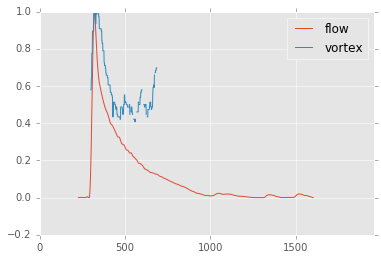

In [650]:
dftmp = df[['flow','vortex']]/df[['flow','vortex']].max()
dftmp.plot()

In [651]:
effort = audio_files[json_selector.value]
file_name = effort['WavFile']

df.to_csv('Results/' + file_name + '.csv')
print 'Results/' + file_name + '.csv'

Results/1464282278.323511.wav.csv




1. 0_1 - Doesn't break, but test is awful

2. 45_0 - NO FRONT WHISTLE; doesn't break, but vortex might extend too far

3. 47_0 - NO FRONT WHISTLE; whistle is grabbed perfectly but vortex back isn't captured because of slope. Missing back whistle.

4. **23_0 - NO FRONT WHISTLE; looks REALLY GOOD... grabbed entire vortex and both whistle components. CLEAN TEST.**

5. 9_0 - Constant whistle, no vortex. Terrible test.

6. 10_0 - Clean whistle components but WEAK VORTEX; vortex is split in mid but is tracked well

7. 42_0 - GREAT TEST; good whistle components with a short from whistle. Curve following is perfect.

8. 17_0 - Marginal test; very flat vortex but decent following. Midsection following is extended past mid

9. 15_0 - Strange test; whistle behaves strangely, vortex is indiscernible 

10. 12_0 - Poor test; whistle is flat and vortex is indiscernible

11. 8_0 - Great test; 



In [ ]:
print vortex_fundamental[vortex_start:vortex_end]

Find max energy, look within a window of ±0.5 seconds to try to find the max frequency
trace back/forward then look at 1/3 for whistle start/end


Feat 1: vortex curve (array with indices of highest magnitude along the curve)
Feat 2: side whistle ends
Feat 3: side whistle peak
Feat 4: feat 2 + (feat 3 / 2) [bring it down to it's harmonic; should be one smooth-ish line)

Reach:
Feat 5: Harmonic of vortex


Go point by point, when looking at next point, examing the max magnitude frequencies of the next index...
First threshold of 100Hz and play with it

- Find side whistle, create a new data array for whistle and it's indices, trace within band until end is found
- Create new data array for whistle harmonic and look at 3x band for whistle harmonic, trace back to beginning
- Trace harmonic till the end (within band)
- Look at 1/3 frequency for end of whistle band, trace back to beginning
- Follow whistle to end
- For any of these points, look for next point within a band of surrounding frequencies before moving elsewhere, if point within the band is > 85% of the actual max, continue within band


- Grab max frequency between frequency of whistle at the end of the beginning section and try to find the beginning of the curve. Keep finding max values in a band around the current frequency


- After finding vortex curve, examine 2nd through 10th harmonics to see if the mean of points in a band of ±10Hz are significantly higher than the mean of points within ±100Hz 